### Incremental Review Scraping with Deduplication and Checkpointing

In [ ]:
from google_play_scraper import Sort, reviews
import pandas as pd
from pathlib import Path
import time
import random
import pickle
from pathlib import Path

# -----------------------
# Resolve project root
# -----------------------
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# -----------------------
# Raw data paths
# -----------------------
RAW_DIR = PROJECT_ROOT / "data" / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

APP_ID = "com.openai.chatgpt"

DATA_FILE = RAW_DIR / "play_reviews_ingested.csv"
TOKEN_FILE = RAW_DIR / "play_reviews_ingested.token.pkl"

def load_existing_ids_and_token():
    """
    Resumable crawling:
    - If CSV exists, load review_id for deduplication
    - Load continuation_token from a pickle file (keeps original object structure)
    """
    existing_ids = set()

    if DATA_FILE.exists():
        df = pd.read_csv(DATA_FILE)
        if "review_id" in df.columns:
            existing_ids = set(df["review_id"].astype(str))

    token = None
    if TOKEN_FILE.exists():
        with open(TOKEN_FILE, "rb") as f:
            token = pickle.load(f)

        # Safety: if token is accidentally saved as string, discard it
        if isinstance(token, str):
            token = None

    return existing_ids, token


def save_token(token):
    """Persist continuation_token (as-is) via pickle for checkpointing"""
    with open(TOKEN_FILE, "wb") as f:
        pickle.dump(token, f)


def append_rows_to_csv(rows):
    """Append new review rows to CSV with schema normalization"""
    if not rows:
        return

    df_new = pd.DataFrame(rows)

    # Normalize column names (fields may vary slightly by library version)
    rename_map = {
        "reviewId": "review_id",
        "userName": "user_name",
        "content": "content",
        "score": "score",
        "at": "at",
        "replyContent": "reply_content",
        "repliedAt": "replied_at",
        "thumbsUpCount": "thumbs_up_count",
        "appVersion": "app_version",
    }
    df_new = df_new.rename(columns=rename_map)

    # Ensure review_id exists and is a string
    if "review_id" not in df_new.columns and "reviewId" in df_new.columns:
        df_new["review_id"] = df_new["reviewId"].astype(str)
    if "review_id" in df_new.columns:
        df_new["review_id"] = df_new["review_id"].astype(str)

    # Append mode (write header only if file does not exist)
    write_header = not DATA_FILE.exists()
    df_new.to_csv(DATA_FILE, mode="a", header=write_header, index=False)


def fetch_reviews(target_new=10000, per_call=200, max_total_calls=2000):
    """
    Incrementally fetch Google Play reviews.

    Parameters:
    - target_new: number of new (unseen) reviews to collect this run
    - per_call: number of reviews per API call
    - max_total_calls: safety cap on total calls
    """
    existing_ids, continuation_token = load_existing_ids_and_token()
    new_rows_buffer = []
    new_count = 0

    start_time = time.time()
    calls = 0
    seen_existing_streak = 0

    print(f"[START] existing reviews: {len(existing_ids):,}")
    print(f"[START] target new reviews: {target_new:,}")
    print(f"[START] resume token: {'Y' if continuation_token else 'N'}")

    while new_count < target_new and calls < max_total_calls:
        calls += 1
        t0 = time.time()

        try:
            result, continuation_token = reviews(
                APP_ID,
                lang="en",
                country="us",
                sort=Sort.NEWEST,
                count=per_call,
                continuation_token=continuation_token,
            )
        except Exception as e:
            # Simple retry with backoff
            wait_s = 2 + random.random() * 2
            print(f"[WARN] call #{calls} failed: {e} | retry after {wait_s:.1f}s")
            time.sleep(wait_s)
            continue

        fetched = len(result)
        added_this_call = 0

        for r in result:
            rid = str(r.get("reviewId") or r.get("review_id") or "")
            if not rid:
                continue
            if rid in existing_ids:
                continue

            existing_ids.add(rid)
            new_rows_buffer.append(r)
            new_count += 1
            added_this_call += 1

            # Flush to disk in batches to avoid memory growth and data loss
            if len(new_rows_buffer) >= 500:
                append_rows_to_csv(new_rows_buffer)
                new_rows_buffer.clear()
                save_token(continuation_token)

            if new_count >= target_new:
                break

        # Track consecutive calls that add 0 new reviews
        if added_this_call == 0:
            seen_existing_streak += 1
        else:
            seen_existing_streak = 0

        dt = time.time() - t0
        elapsed = time.time() - start_time
        rate = new_count / elapsed if elapsed > 0 else 0

        print(
            f"[{calls:04d}] fetched={fetched:3d} added={added_this_call:3d} "
            f"total_new={new_count:,} token={'Y' if continuation_token else 'N'} "
            f"dt={dt:.2f}s rate={rate:.2f}/s"
        )

        # Stop if we keep getting only duplicates (likely saturated/paging loop)
        if seen_existing_streak >= 20:
            print("[STOP] too many consecutive calls with 0 new reviews (likely saturated or paging loop).")
            break

        # Mild randomized sleep to avoid aggressive request pattern
        time.sleep(0.3 + random.random() * 0.3)

        # No token means no more pages
        if not continuation_token:
            print("[STOP] continuation_token is None (no more pages).")
            break

    # Final flush
    if new_rows_buffer:
        append_rows_to_csv(new_rows_buffer)
        new_rows_buffer.clear()
        save_token(continuation_token)

    total_elapsed = time.time() - start_time
    print(f"[DONE] new added: {new_count:,} | total elapsed: {total_elapsed/60:.1f} min")
    print(f"[DONE] saved to: {DATA_FILE.resolve()}")
    print(f"[DONE] token saved to: {TOKEN_FILE.resolve()}")


# Run example: fetch 10,000 new reviews
fetch_reviews(target_new=10000, per_call=200)


[START] existing reviews: 16,880
[START] target new reviews: 10,000
[START] resume token: N
[0001] fetched=200 added=200 total_new=200 token=Y dt=0.53s rate=378.93/s
[0002] fetched=200 added=199 total_new=399 token=Y dt=0.42s rate=258.25/s
[0003] fetched=200 added=200 total_new=599 token=Y dt=0.43s rate=259.26/s
[0004] fetched=200 added=200 total_new=799 token=Y dt=0.48s rate=246.65/s
[0005] fetched=200 added=200 total_new=999 token=Y dt=0.44s rate=242.10/s
[0006] fetched=200 added=200 total_new=1,199 token=Y dt=0.43s rate=237.04/s
[0007] fetched=200 added=200 total_new=1,399 token=Y dt=0.38s rate=241.26/s
[0008] fetched=200 added=200 total_new=1,599 token=Y dt=0.40s rate=245.00/s
[0009] fetched=200 added=200 total_new=1,799 token=Y dt=0.42s rate=241.99/s
[0010] fetched=200 added=200 total_new=1,999 token=Y dt=0.40s rate=240.27/s
[0011] fetched=200 added=200 total_new=2,199 token=Y dt=0.57s rate=238.00/s
[0012] fetched=200 added=200 total_new=2,399 token=Y dt=0.47s rate=236.31/s
[0013]

### Check Data Shape

After implementing a resumable ingestion pipeline, I validated the dataset by checking its shape, schema consistency, and sample records to ensure data integrity before downstream analysis.

In [4]:
import pandas as pd

df = pd.read_csv(DATA_FILE)

print("shape:", df.shape)
print("columns:", df.columns.tolist())
df.head(3)


shape: (26880, 11)
columns: ['review_id', 'user_name', 'user_image_url', 'review_text', 'rating', 'thumbs_up', 'review_created_version', 'review_time', 'reply_text', 'reply_time', 'app_version']


,review_id,user_name,user_image_url,review_text,rating,thumbs_up,review_created_version,review_time,reply_text,reply_time,app_version
0,2876fe36-e40d-45e4-98c6-509d937232a9,Mahakal Gulshan Sharma,https://play-lh.googleusercontent.com/a-/ALV-U...,radhe radhe,3,0,NaN,2025-12-29 10:43:25,NaN,NaN,NaN
1,f45da16f-dd83-4224-8093-d857a616afb9,Donthi Naresh,https://play-lh.googleusercontent.com/a/ACg8oc...,super,5,0,1.2025.350,2025-12-29 10:41:40,NaN,NaN,1.2025.350
2,6af6aec0-a07b-4ffc-8b27-5231ebf1ff23,Royrex Ndlovu,https://play-lh.googleusercontent.com/a-/ALV-U...,ultra super app,5,0,1.2025.350,2025-12-29 10:41:21,NaN,NaN,1.2025.350


## Schema Alignment (Canonical Columns)

To ensure consistency between ingestion, analysis, and downstream storage,
we normalize column names and data types to match the canonical data schema.


In [5]:
CANONICAL_RENAME = {
    "thumbs_up": "thumbs_up_count",
    "review_created_version": "app_version",
    "reply_text": "reply_content",
    "reply_time": "replied_at",
}

df = df.rename(columns={k: v for k, v in CANONICAL_RENAME.items() if k in df.columns})

# ensure canonical dtypes
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["review_time"] = pd.to_datetime(df["review_time"], errors="coerce")
df["thumbs_up_count"] = pd.to_numeric(df["thumbs_up_count"], errors="coerce").fillna(0).astype(int)

df = df.loc[:, ~df.columns.duplicated()]

df.columns.tolist()


['review_id',
 'user_name',
 'user_image_url',
 'review_text',
 'rating',
 'thumbs_up_count',
 'app_version',
 'review_time',
 'reply_content',
 'replied_at']

After alignment, the dataframe represents the canonical `reviews` table
as defined in `DATA_SCHEMA.md`.


## EDA
All analyses below operate on the canonical `reviews` table
after schema alignment.


### Data Preprocessing and Basic Feature Engineering


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


print("Rows:", len(df))

# -------- Basic feature engineering --------
df["review_len"] = df["review_text"].str.len()
df["word_count"] = df["review_text"].str.split().str.len()

# -------- Missing value check (quick sanity check) --------
print("\nMissing rate:")
print(df[["rating", "review_time", "review_len", "word_count"]].isna().mean())

Rows: 26880

Missing rate:
rating         0.0
review_time    0.0
review_len     0.0
word_count     0.0
dtype: float64


### Descriptive Statistics and Rating Distribution

             rating    review_len    word_count
count  26880.000000  26880.000000  26880.000000
mean       4.522173     30.097173      5.876190
std        1.082806     60.022417     10.978806
min        1.000000      1.000000      1.000000
25%        5.000000      6.000000      1.000000
50%        5.000000     11.000000      2.000000
75%        5.000000     27.000000      5.000000
max        5.000000    500.000000    120.000000


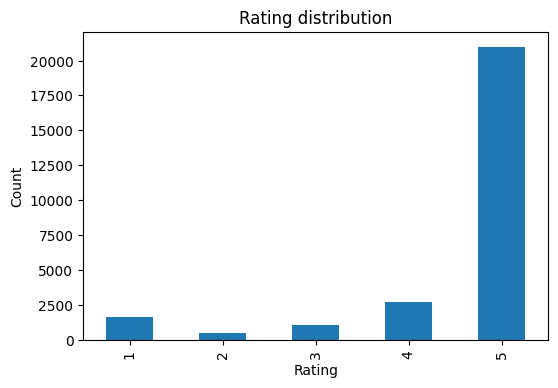

In [7]:
# Descriptive statistics
print(
    df[["rating", "review_len", "word_count"]]
    .describe()
)

# Rating distribution
plt.figure(figsize=(6, 4))

# (Optional) drop NaN ratings for robustness
rating_counts = df["rating"].dropna().value_counts().sort_index()

rating_counts.plot(kind="bar")
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


### Temporal Analysis of Ratings (Hourly Trends)

min: 2025-12-29 09:18:25
max: 2026-01-13 17:44:56
unique days: 10
unique weeks: 3
Hourly points: 195
hour
2025-12-29 09:00:00    4.650000
2025-12-29 10:00:00    4.470000
2026-01-01 04:00:00    4.577778
2026-01-01 05:00:00    4.433333
2026-01-01 06:00:00    4.500000
Name: rating, dtype: float64


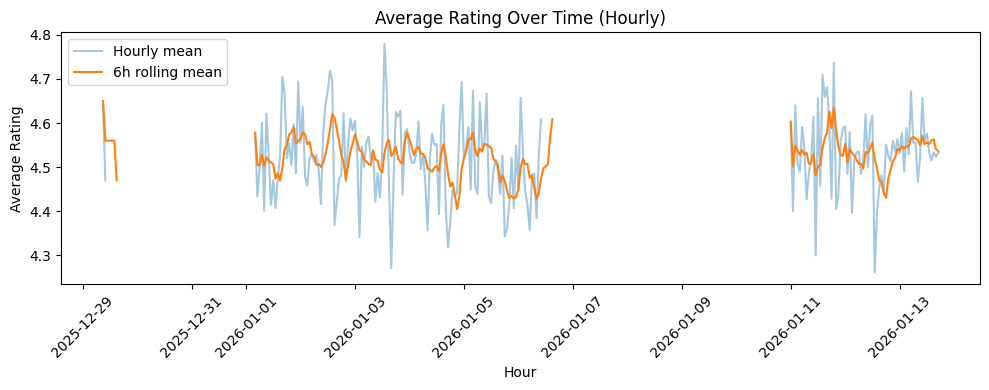

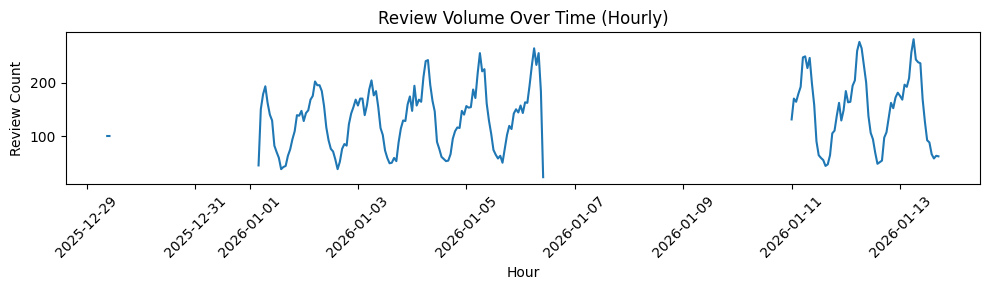

In [8]:
import matplotlib.pyplot as plt

# Assumes df is already schema-aligned (canonical columns) from earlier steps:
# - rating (numeric)
# - review_time (datetime or convertible)
# This cell performs an hourly trend analysis and adds a smoothing line (bonus).

# (Optional safety check)
df["review_time"] = pd.to_datetime(df["review_time"], errors="coerce")

# Inspect temporal coverage
print("min:", df["review_time"].min())
print("max:", df["review_time"].max())
print("unique days:", df["review_time"].dt.date.nunique())
print("unique weeks:", df["review_time"].dt.to_period("W").nunique())

# Keep only rows with valid timestamps and ratings
df_time = df.dropna(subset=["review_time", "rating"]).copy()

# Aggregate at hourly level
df_time["hour"] = df_time["review_time"].dt.floor("h")
hourly_avg = df_time.groupby("hour")["rating"].mean()

# Optional: also compute hourly counts to contextualize the mean
hourly_count = df_time.groupby("hour")["rating"].size()

print("Hourly points:", len(hourly_avg))
print(hourly_avg.head())

# Create a complete hourly index so missing hours appear as gaps (not misleading connections)
full_hours = pd.date_range(
    start=hourly_avg.index.min(),
    end=hourly_avg.index.max(),
    freq="h"
)

hourly_avg = hourly_avg.reindex(full_hours)
hourly_count = hourly_count.reindex(full_hours)

# Bonus: rolling smoothing to make trends easier to see
# (6-hour rolling mean is a reasonable default for short horizons)
hourly_smooth = hourly_avg.rolling(6, min_periods=1).mean()

# Plot hourly mean + smoothed trend
plt.figure(figsize=(10, 4))
plt.plot(hourly_avg.index, hourly_avg.values, linestyle="-", alpha=0.4, label="Hourly mean")
plt.plot(hourly_smooth.index, hourly_smooth.values, linestyle="-", label="6h rolling mean")
plt.title("Average Rating Over Time (Hourly)")
plt.xlabel("Hour")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# (Optional bonus) Plot hourly sample size to show coverage / reliability
plt.figure(figsize=(10, 3))
plt.plot(hourly_count.index, hourly_count.values, linestyle="-")
plt.title("Review Volume Over Time (Hourly)")
plt.xlabel("Hour")
plt.ylabel("Review Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Relationship Between Review Length and Rating

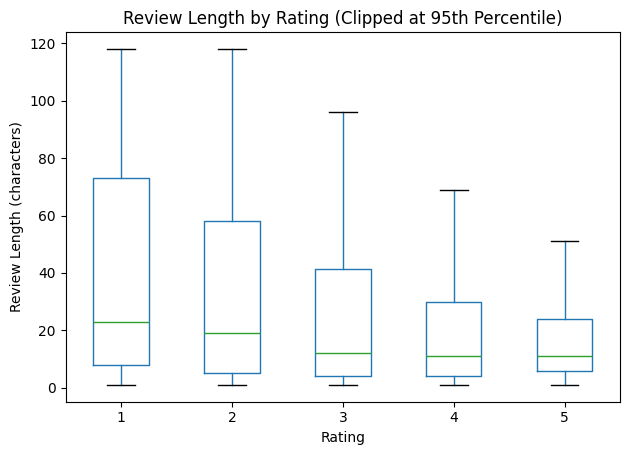

Median review length by rating:
rating
1    23.0
2    19.0
3    12.0
4    11.0
5    11.0
Name: median_review_length, dtype: float64


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

plot_df = df.copy()

upper_bound = plot_df["review_len"].quantile(0.95)
plot_df["review_len_clip"] = plot_df["review_len"].clip(upper=upper_bound)

ax = plot_df.boxplot(
    column="review_len_clip",
    by="rating",
    grid=False,
    showfliers=False  # ✅ 关键：不画离群点
)

plt.suptitle("")
plt.title("Review Length by Rating (Clipped at 95th Percentile)")
plt.xlabel("Rating")
plt.ylabel("Review Length (characters)")
plt.tight_layout()
plt.show()

median_lengths = (
    df.groupby("rating")["review_len"]
    .median()
    .rename("median_review_length")
)

print("Median review length by rating:")
print(median_lengths)



### Rating Comparison Across App Versions

Top app versions summary (with uncertainty):
                 n  avg_rating      ci95    avg_len
app_version                                        
1.2025.294      58    4.689655  0.199973  29.034483
1.2025.302      94    4.489362  0.209093  29.053191
1.2025.308     118    4.576271  0.183350  22.915254
1.2025.315     110    4.463636  0.212815  25.300000
1.2025.322     143    4.594406  0.168724  28.888112
1.2025.329     311    4.430868  0.126919  30.569132
1.2025.336     426    4.551643  0.096554  25.474178
1.2025.343     698    4.551576  0.076578  24.276504
1.2025.350   21007    4.560337  0.013919  28.883705
1.2026.006    1819    4.544255  0.047998  29.704783


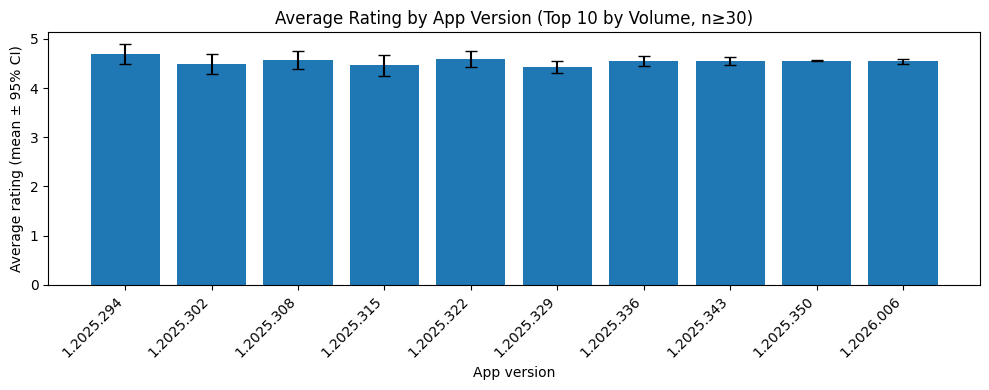

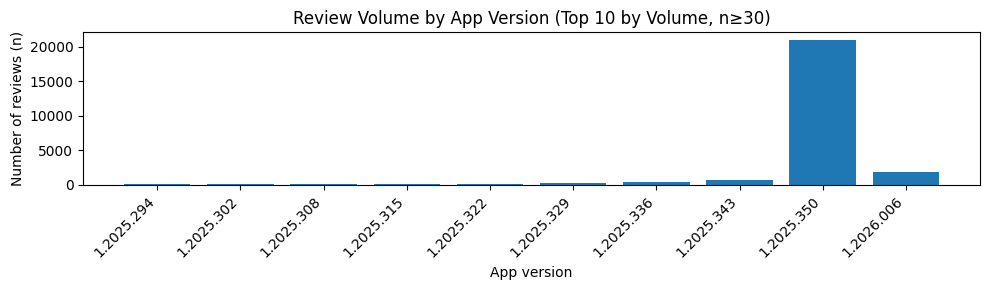

In [10]:
# ------------------------------
# Rating comparison across app versions (enhanced)
# ------------------------------

# Keep only rows with app_version and rating
dv = df.dropna(subset=["app_version", "rating"]).copy()

# Optional: ensure correct dtypes
dv["rating"] = pd.to_numeric(dv["rating"], errors="coerce")
dv = dv.dropna(subset=["rating"])

# Focus on the most common versions (top K by volume)
TOP_K = 10
top_versions = dv["app_version"].value_counts().head(TOP_K).index
dv = dv[dv["app_version"].isin(top_versions)]

# Compute per-version summary with uncertainty
# - n: sample size
# - avg_rating: mean rating
# - se: standard error of the mean
# - ci95: 95% confidence interval half-width
version_stats = (
    dv.groupby("app_version")
      .agg(
          n=("rating", "size"),
          avg_rating=("rating", "mean"),
          std_rating=("rating", "std"),
          avg_len=("review_len", "mean"),
      )
)

version_stats["se"] = version_stats["std_rating"] / np.sqrt(version_stats["n"])
version_stats["ci95"] = 1.96 * version_stats["se"]

# OPTIONAL but recommended: filter tiny-n versions for interpretability
# (If you want to keep all topK no matter what, set MIN_N=1)
MIN_N = 30
version_stats = version_stats[version_stats["n"] >= MIN_N].copy()

# Sort by version string for readability (or by avg_rating if you prefer)
version_stats = version_stats.sort_index()

print("Top app versions summary (with uncertainty):")
print(version_stats[["n", "avg_rating", "ci95", "avg_len"]])

# ------------------------------
# Plot 1: Average rating by version with 95% CI error bars
# ------------------------------
plt.figure(figsize=(10, 4))
plt.bar(
    version_stats.index.astype(str),
    version_stats["avg_rating"].values,
    yerr=version_stats["ci95"].values,  # uncertainty
    capsize=4
)
plt.title(f"Average Rating by App Version (Top {TOP_K} by Volume, n≥{MIN_N})")
plt.xlabel("App version")
plt.ylabel("Average rating (mean ± 95% CI)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------
# Plot 2 (bonus): Sample size by version (context)
# ------------------------------
plt.figure(figsize=(10, 3))
plt.bar(version_stats.index.astype(str), version_stats["n"].values)
plt.title(f"Review Volume by App Version (Top {TOP_K} by Volume, n≥{MIN_N})")
plt.xlabel("App version")
plt.ylabel("Number of reviews (n)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

sia = SentimentIntensityAnalyzer()


df["sentiment"] = df["review_text"].astype(str).apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

df[["rating", "sentiment"]].head()


,rating,sentiment
0,3,0.0000
1,5,0.5994
2,5,0.5994
3,5,0.6249
4,1,0.0000


<Figure size 640x480 with 0 Axes>

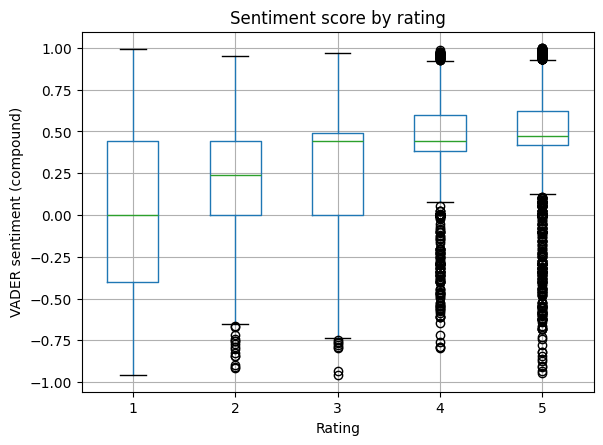

In [13]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column="sentiment", by="rating")
plt.suptitle("")
plt.title("Sentiment score by rating")
plt.xlabel("Rating")
plt.ylabel("VADER sentiment (compound)")
plt.show()


## Sentiment–Rating Alignment and Low-Rating Theme Mining (Bigrams)

This section validates that sentiment scores align with numeric ratings, then extracts the most frequent bigrams from low-rating reviews (1–2 stars) to surface common complaint themes.


In [16]:
import re
from collections import Counter

# ------------------------------
# 1) Sentiment–rating alignment (sanity check)
# ------------------------------

# Ensure sentiment is numeric (robust to NaNs / strings)
df["sentiment"] = pd.to_numeric(df["sentiment"], errors="coerce")

sentiment_by_rating = (
    df.dropna(subset=["rating", "sentiment"])
      .groupby("rating")["sentiment"]
      .mean()
      .sort_index()
)

print("Mean sentiment by rating:")
print(sentiment_by_rating)

# Optional: quick visualization (bonus)
# (Uncomment if you want a quick plot)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(6, 3))
# sentiment_by_rating.plot(kind="bar")
# plt.title("Mean Sentiment by Rating")
# plt.xlabel("Rating")
# plt.ylabel("Mean sentiment")
# plt.tight_layout()
# plt.show()

# ------------------------------
# 2) Bigram mining for themes (low vs high ratings)
# ------------------------------

# Stopwords: prefer sklearn to avoid nltk downloads in notebooks
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
STOP_WORDS = set(ENGLISH_STOP_WORDS)

def tokenize(text: str):
    """
    Basic tokenizer:
    - lowercase
    - keep only letters/spaces
    - remove stopwords
    - remove short tokens (len <= 2)
    """
    if not isinstance(text, str):
        return []
    tokens = re.sub(r"[^a-zA-Z\s]", " ", text.lower()).split()
    tokens = [t for t in tokens if t not in STOP_WORDS and len(t) > 2]
    return tokens

def top_bigrams(text_series: pd.Series, top_n: int = 20):
    """
    Extract top bigrams from a pandas Series of texts.
    Returns a DataFrame with columns: bigram, count
    """
    bigrams_list = []
    for txt in text_series.dropna():
        toks = tokenize(txt)
        bigrams_list.extend(list(zip(toks, toks[1:])))  # adjacent pairs

    counts = Counter(bigrams_list).most_common(top_n)
    out = pd.DataFrame(counts, columns=["bigram", "count"])
    out["bigram"] = out["bigram"].apply(lambda x: " ".join(x))
    return out

# Low rating (1–2)
low_df = df[df["rating"].isin([1, 2])].copy()
print("\nLow-rating reviews (1–2 stars):", len(low_df))

low_bigrams = top_bigrams(low_df["review_text"], top_n=20)
print("\nTop bigrams in low-rating reviews:")
display(low_bigrams)

# Bonus: High rating (4–5) for contrast
high_df = df[df["rating"].isin([4, 5])].copy()
print("\nHigh-rating reviews (4–5 stars):", len(high_df))

high_bigrams = top_bigrams(high_df["review_text"], top_n=20)
print("\nTop bigrams in high-rating reviews (contrast):")
display(high_bigrams)

Mean sentiment by rating:
rating
1   -0.003737
2    0.189491
3    0.306707
4    0.412039
5    0.455087
Name: sentiment, dtype: float64

Low-rating reviews (1–2 stars): 2118

Top bigrams in low-rating reviews:


,bigram,count
0,chat gpt,53
1,bad app,25
2,good app,23
3,worst app,20
4,wrong information,19
5,nice app,19
6,wrong answers,19
7,gives wrong,16
8,don use,16
9,waste time,14



High-rating reviews (4–5 stars): 23683

Top bigrams in high-rating reviews (contrast):


,bigram,count
0,best app,715
1,good app,706
2,nice app,492
3,chat gpt,367
4,love app,226
5,great app,193
6,app good,134
7,useful app,122
8,amazing app,101
9,helpful app,101


## Low-Rating Review Themes: Evidence and Examples

Building on the bigram frequency analysis, this section surfaces representative review excerpts
and groups common complaint patterns into interpretable themes. This helps translate n-gram
statistics into concrete user pain points.


In [17]:
# ------------------------------
# Part A: Representative examples for top low-rating bigrams
# ------------------------------

def example_reviews_for_bigram(df_subset, bigram, max_examples=2):
    """
    Return up to `max_examples` representative review texts
    containing the given bigram.
    """
    w1, w2 = bigram.split()
    mask = df_subset["review_text"].str.lower().str.contains(
        rf"\b{w1}\s+{w2}\b", regex=True, na=False
    )
    examples = (
        df_subset.loc[mask, "review_text"]
        .dropna()
        .head(max_examples)
        .tolist()
    )
    return examples

# Take top N bigrams from low-rating reviews
TOP_N = 8
top_low_bigrams = low_bigrams.head(TOP_N)

evidence_rows = []

for _, row in top_low_bigrams.iterrows():
    bg = row["bigram"]
    cnt = row["count"]
    examples = example_reviews_for_bigram(low_df, bg, max_examples=2)

    evidence_rows.append({
        "bigram": bg,
        "count": cnt,
        "example_reviews": examples
    })

evidence_df = pd.DataFrame(evidence_rows)

print("Representative examples for top low-rating bigrams:")
display(evidence_df)


Representative examples for top low-rating bigrams:


,bigram,count,example_reviews
0,chat gpt,53,"[ek no faltu aahe chat Gpt, chat gpt kam nehi ..."
1,bad app,25,"[bad app, bad app phoo]"
2,good app,23,"[good app, good app]"
3,worst app,20,"[worst app, worst app only premium users only ..."
4,wrong information,19,[Update: stopped using it altogether and using...
5,nice app,19,"[very very very nice app, nice app]"
6,wrong answers,19,"[This app gives wrong answers again and again,..."
7,gives wrong,16,[Update: stopped using it altogether and using...


In [18]:
# ------------------------------
# Part B: Lightweight theme grouping for low-rating reviews
# ------------------------------

THEMES = {
    "Functionality / Bugs": [
        "doesn work", "not work", "crash", "bug", "error", "fix"
    ],
    "Incorrect or Low-Quality Output": [
        "wrong information", "wrong answer", "incorrect", "fake", "hallucination"
    ],
    "Poor User Experience": [
        "waste time", "bad experience", "dont use", "dont download"
    ],
    "Audio / Read-Aloud Issues": [
        "read aloud", "voice", "audio"
    ]
}


In [19]:
def assign_themes(text):
    if not isinstance(text, str):
        return []
    text_l = text.lower()
    matched = []
    for theme, keywords in THEMES.items():
        for kw in keywords:
            if kw in text_l:
                matched.append(theme)
                break
    return matched

low_df["themes"] = low_df["review_text"].apply(assign_themes)

# Explode for counting
theme_counts = (
    low_df.explode("themes")
          .dropna(subset=["themes"])
          .groupby("themes")
          .size()
          .sort_values(ascending=False)
)

print("Low-rating review themes (counts):")
print(theme_counts)


Low-rating review themes (counts):
themes
Functionality / Bugs               97
Incorrect or Low-Quality Output    75
Audio / Read-Aloud Issues          25
Poor User Experience               12
dtype: int64


 ### Sentiment Analysis with VADER and Alignment with Ratings

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\y8qia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


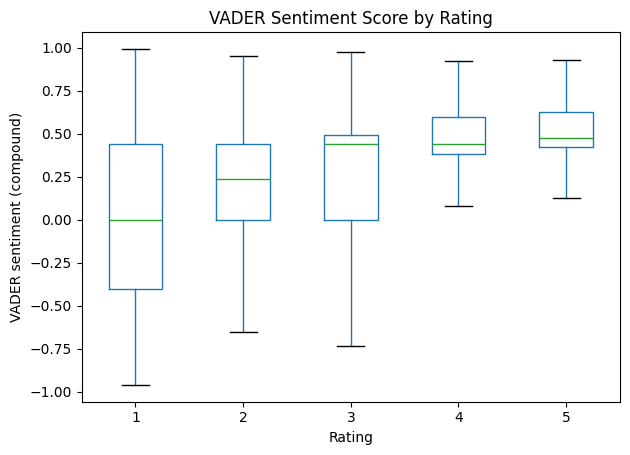

Mean sentiment by rating:
rating
1   -0.003737
2    0.189491
3    0.306707
4    0.412039
5    0.455087
Name: sentiment, dtype: float64

Spearman correlation between rating and sentiment:
rho = 0.235, p-value = 0.000e+00


In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ------------------------------
# Sentiment computation (VADER)
# ------------------------------

# Download once; safe if already present
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Ensure review_text is string
df["review_text"] = df["review_text"].astype(str)

df["sentiment"] = df["review_text"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# ------------------------------
# Sentiment vs rating: distribution
# ------------------------------

ax = df.boxplot(
    column="sentiment",
    by="rating",
    grid=False,
    showfliers=False  # hide extreme outliers for readability
)

plt.suptitle("")  # remove pandas default title
plt.title("VADER Sentiment Score by Rating")
plt.xlabel("Rating")
plt.ylabel("VADER sentiment (compound)")
plt.tight_layout()
plt.show()

# ------------------------------
# Mean sentiment by rating
# ------------------------------

sentiment_by_rating = (
    df.groupby("rating")["sentiment"]
      .mean()
      .sort_index()
)

print("Mean sentiment by rating:")
print(sentiment_by_rating)

# ------------------------------
# Quantitative alignment check (bonus)
# ------------------------------

valid_df = df.dropna(subset=["rating", "sentiment"])
corr, pval = spearmanr(valid_df["rating"], valid_df["sentiment"])

print("\nSpearman correlation between rating and sentiment:")
print(f"rho = {corr:.3f}, p-value = {pval:.3e}")


## Save Processed Dataset

This section saves the schema-aligned and feature-enriched dataset
to a stable location for downstream use and reproducibility.

In [21]:
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

PROCESSED_FILE = PROCESSED_DIR / "reviews_enriched.csv"

# -----------------------
# Save processed dataset
# -----------------------
df.to_csv(PROCESSED_FILE, index=False)

print("Processed dataset saved successfully.")
print("Path:", PROCESSED_FILE.resolve())
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")

Processed dataset saved successfully.
Path: D:\intern PROJECT\google-play-reviews\data\processed\reviews_enriched.csv
Rows: 26880, Columns: 13
